In [16]:
import os
import torch
import numpy as np
from pycocotools.coco import COCO
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import wandb

In [17]:
annotation_file = 'data/raw/annotations.json'  # use instances_val2017.json or train2017
image_dir = 'data/raw/images'

coco = COCO(annotation_file)

loading annotations into memory...
Done (t=0.27s)
creating index...
index created!


In [18]:
# # Build a mapping from COCO category_id → contiguous index (0 to N-1)
# cat_ids = sorted(coco.getCatIds())
# cat_id_to_index = {cat_id: idx for idx, cat_id in enumerate(cat_ids)}
# index_to_cat_id = {idx: cat_id for cat_id, idx in cat_id_to_index.items()}

# # Final number of output classes
# num_classes = len(cat_id_to_index)
# print("num_classes =", num_classes)

In [19]:
# Define SegmentationDataset Class
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path))  # single-channel with class IDs

        # Apply transforms (augmentation + normalization)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return image, mask.long()

In [20]:
# Define Transformations
def get_train_transform(resize=256):
    return A.Compose([
        A.Resize(resize, resize),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

def get_val_transform(resize=256):
    return A.Compose([
        A.Resize(resize, resize),
        A.Normalize(mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape: torch.Size([4, 3, 256, 256])
Mask shape: torch.Size([4, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


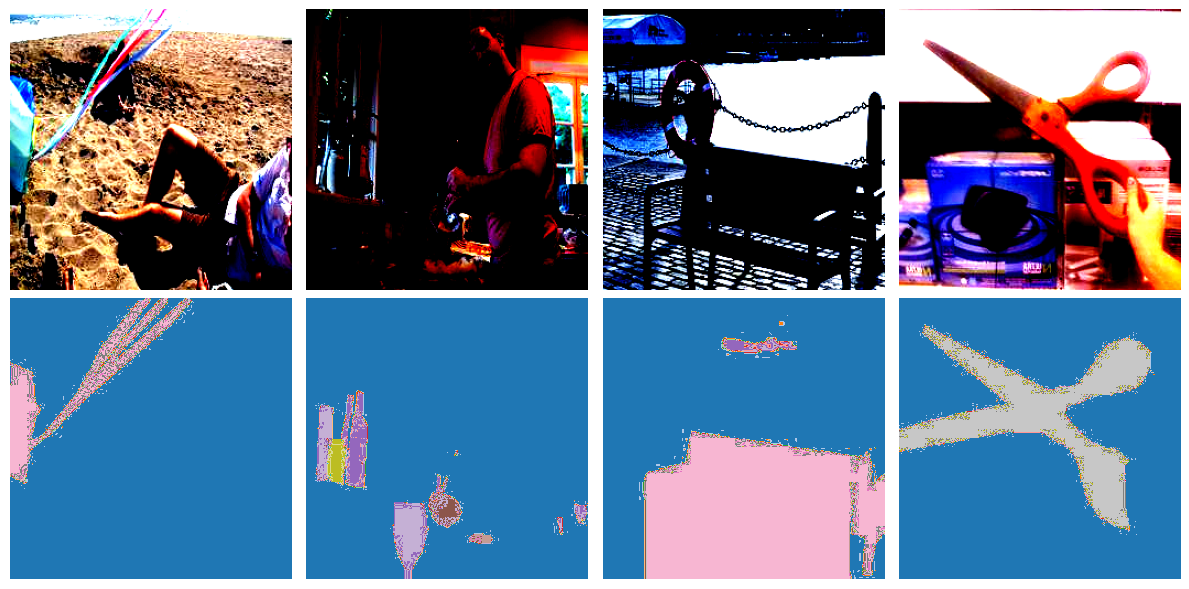

In [21]:
# Load Dataset and Visualize Sample
train_dataset = SegmentationDataset(
    image_dir="data/processed/images",
    mask_dir="data/processed/masks",
    transform=get_train_transform()
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Preview a batch
images, masks = next(iter(train_loader))
print("Image shape:", images.shape)
print("Mask shape:", masks.shape)

# Plot
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i].permute(1, 2, 0).numpy())
    plt.axis("off")

    plt.subplot(2, 4, i+5)
    plt.imshow(masks[i].numpy(), cmap='tab20')
    plt.axis("off")
plt.tight_layout()
plt.show()

# UNET

In [34]:
import segmentation_models_pytorch as smp

# Define the model
def get_model(num_classes, encoder_name="resnet18"):
    model = smp.Unet(
        encoder_name=encoder_name,
        encoder_weights="imagenet",
        in_channels=3,
        classes=num_classes
    )
    return model

# num_classes = 90
# num_classes = len(np.unique([np.array(Image.open(f"data/processed/masks/{f}")) for f in os.listdir("data/processed/masks")]).flatten())+1

In [35]:
from segmentation_models_pytorch.utils.metrics import IoU, Fscore

# These require probability maps and class index masks
iou_metric = IoU(threshold=0.5)
dice_metric = Fscore(threshold=0.5)

In [ ]:
import wandb

wandb.login()  # Run this once if needed

# Initialize a new run
wandb.init(
    project="segmentation-assignment",
    name="unet-run-3",
    config={
        "epochs": 20,
        "batch_size": 32,
        "encoder": "resnet50",
        "resize": 256,
        "lr": 1e-3,
        "loss": "CrossEntropy",
        "model": "UNet",
        "num_classes": num_classes
    }
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: rajarshi3998 (rajarshi3998-indian-institute-of-science) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [10]:
import torch
from torch.optim import Adam
from tqdm.notebook import tqdm
import torch.nn as nn
from segmentation_models_pytorch.utils.metrics import IoU, Fscore
# %env CUDA_LAUNCH_BLOCKING=1

# Loss function
criterion = nn.CrossEntropyLoss()

# Metrics (optional, for future validation use)
iou_metric = IoU(threshold=0.5)
dice_metric = Fscore(threshold=0.5)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes).to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

def train_one_epoch(loader, model, optimizer):
    model.train()
    total_loss = 0
    for images, masks in tqdm(loader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)  # (B, C, H, W)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    wandb.log({"train_loss": avg_loss})
    print(f"Train Loss: {avg_loss:.4f}")

In [12]:
# import numpy as np
# from PIL import Image
# import os

# mask_dir = "data/processed/masks"
# all_classes = set()

# for fname in os.listdir(mask_dir):
#     mask = np.array(Image.open(os.path.join(mask_dir, fname)))
#     all_classes.update(np.unique(mask))

# all_classes = sorted(all_classes)
# print("Unique classes found:", all_classes)

# num_classes = max(all_classes) + 1
# print("Final num_classes to use:", num_classes)

In [13]:
# model = get_model(num_classes).to(device)

In [14]:
# model = get_model(num_classes).to(device)

In [40]:
# print("Output shape:", outputs.shape)  # (B, C, H, W)
# print("Target shape:", masks.shape)    # (B, H, W)
# print("Max label in target:", masks.max().item())
# print("num_classes:", num_classes)


In [15]:
# num_classes = max(all_classes) + 1
# num_classes

Classes in masks: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 131, 132]
num_classes to use: 133


In [11]:
# num_epochs = 20
# for epoch in range(num_epochs):
#     print(f"Epoch {epoch+1}/{num_epochs}")
#     train_one_epoch(train_loader, model, optimizer)
#     wandb.log({"epoch": epoch + 1})

In [ ]:
from sklearn.model_selection import train_test_split

all_images = sorted(os.listdir("data/processed/images"))
train_imgs, val_imgs = train_test_split(all_images, test_size=0.1, random_state=42)

class SplitSegDataset(SegmentationDataset):
    def __init__(self, image_list, image_dir, mask_dir, transform=None):
        super().__init__(image_dir, mask_dir, transform)
        self.images = image_list
        self.masks = image_list  # same filenames

# Datasets
# Reload datasets using remapping
train_dataset = SplitSegDataset(train_imgs, "data/processed/images", "data/processed/masks",
                                transform=get_train_transform(), remap_dict=cat_id_to_index)

val_dataset = SplitSegDataset(val_imgs, "data/processed/images", "data/processed/masks",
                              transform=get_val_transform(), remap_dict=cat_id_to_index)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)



In [12]:
def val_one_epoch(loader, model):
    model.eval()
    total_loss = 0
    ious, dices = [], []

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)  # (B, C, H, W)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)

            iou = iou_metric(preds, masks)
            dice = dice_metric(preds, masks)

            ious.append(iou.item())
            dices.append(dice.item())

    avg_loss = total_loss / len(loader)
    avg_iou = np.mean(ious)
    avg_dice = np.mean(dices)

    wandb.log({"val_loss": avg_loss, "val_iou": avg_iou, "val_dice": avg_dice})
    print(f"Val Loss: {avg_loss:.4f} | IoU: {avg_iou:.4f} | Dice: {avg_dice:.4f}")
    return avg_loss


In [13]:
num_epochs = 20
best_val_loss = float("inf")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_one_epoch(train_loader, model, optimizer)
    val_loss = val_one_epoch(val_loader, model)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        wandb.save("best_model_Unet.pth")


Epoch 1/20


  0%|          | 0/1125 [00:00<?, ?it/s]

Train Loss: 1.6840
Val Loss: 1.5551 | IoU: 0.2412 | Dice: 0.3408

Epoch 2/20


  0%|          | 0/1125 [00:00<?, ?it/s]

Train Loss: 1.5531
Val Loss: 1.4432 | IoU: 0.3720 | Dice: 0.4547

Epoch 3/20


  0%|          | 0/1125 [00:00<?, ?it/s]

Train Loss: 1.5182
Val Loss: 1.4170 | IoU: 0.3597 | Dice: 0.4360

Epoch 4/20


  0%|          | 0/1125 [00:00<?, ?it/s]

Train Loss: 1.4926
Val Loss: 1.3755 | IoU: 0.4219 | Dice: 0.4826

Epoch 5/20


  0%|          | 0/1125 [00:00<?, ?it/s]

Train Loss: 1.4568
Val Loss: 1.3708 | IoU: 0.1373 | Dice: 0.2088

Epoch 6/20


  0%|          | 0/1125 [00:00<?, ?it/s]

Train Loss: 1.4372
Val Loss: 1.3344 | IoU: 0.2929 | Dice: 0.3362

Epoch 7/20


  0%|          | 0/1125 [00:00<?, ?it/s]

Train Loss: 1.4147
Val Loss: 1.3323 | IoU: 0.2669 | Dice: 0.3341

Epoch 8/20


  0%|          | 0/1125 [00:00<?, ?it/s]

Train Loss: 1.3961
Val Loss: 1.3460 | IoU: 0.2450 | Dice: 0.3049

Epoch 9/20


  0%|          | 0/1125 [00:00<?, ?it/s]

Train Loss: 1.3800
Val Loss: 1.3185 | IoU: 0.2334 | Dice: 0.2937

Epoch 10/20


  0%|          | 0/1125 [00:00<?, ?it/s]

Train Loss: 1.3587
Val Loss: 1.2821 | IoU: 0.2576 | Dice: 0.3327

Epoch 11/20


  0%|          | 0/1125 [00:00<?, ?it/s]

Train Loss: 1.3370
Val Loss: 1.2985 | IoU: 0.6869 | Dice: 0.5933

Epoch 12/20


  0%|          | 0/1125 [00:00<?, ?it/s]

Train Loss: 1.3240
Val Loss: 1.2747 | IoU: 0.1950 | Dice: 0.2575

Epoch 13/20


  0%|          | 0/1125 [00:00<?, ?it/s]

Train Loss: 1.3079
Val Loss: 1.2558 | IoU: 0.2490 | Dice: 0.3159

Epoch 14/20


  0%|          | 0/1125 [00:00<?, ?it/s]

Train Loss: 1.2862
Val Loss: 1.2891 | IoU: 0.4208 | Dice: 0.4540

Epoch 15/20


  0%|          | 0/1125 [00:00<?, ?it/s]

Train Loss: 1.2840
Val Loss: 1.2393 | IoU: 0.5719 | Dice: 0.5750

Epoch 16/20


  0%|          | 0/1125 [00:00<?, ?it/s]

Train Loss: 1.2581
Val Loss: 1.2245 | IoU: 0.3005 | Dice: 0.3657

Epoch 17/20


  0%|          | 0/1125 [00:00<?, ?it/s]

Train Loss: 1.2442
Val Loss: 1.2443 | IoU: 0.2910 | Dice: 0.3730

Epoch 18/20


  0%|          | 0/1125 [00:00<?, ?it/s]

Train Loss: 1.2275
Val Loss: 1.2332 | IoU: 0.4331 | Dice: 0.4963

Epoch 19/20


  0%|          | 0/1125 [00:00<?, ?it/s]

Train Loss: 1.2134
Val Loss: 1.2413 | IoU: 0.4705 | Dice: 0.5135

Epoch 20/20


  0%|          | 0/1125 [00:00<?, ?it/s]

Train Loss: 1.1939
Val Loss: 1.1980 | IoU: 0.4146 | Dice: 0.4724


# Segformer

In [22]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import wandb
import numpy as np
import os

from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor

In [23]:
wandb.login()

wandb.init(
    project="segmentation-transformer",
    name="segformer-run-1",
    config={
        "model": "Segformer-B0",
        "epochs": 10,
        "batch_size": 4,
        "lr": 5e-5,
        "resize": 256,
        "loss": "CrossEntropy"
    }
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [24]:
cat_ids = sorted(coco.getCatIds())
cat_id_to_index = {cat_id: idx for idx, cat_id in enumerate(cat_ids)}
num_classes = len(cat_id_to_index)

In [ ]:
# Define model and feature extractor
num_classes = num_classes  # Set correctly
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=num_classes,
    ignore_mismatched_sizes=True
).to("cuda" if torch.cuda.is_available() else "cpu")

feature_extractor = SegformerFeatureExtractor(reduce_labels=False)

In [10]:
class TransformerSegDataset(Dataset):
    def __init__(self, image_list, image_dir, mask_dir, feature_extractor, remap_dict, size=256):
        self.images = image_list
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.feature_extractor = feature_extractor
        self.remap_dict = remap_dict
        self.size = size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        fname = self.images[idx]
        img_path = os.path.join(self.image_dir, fname)
        mask_path = os.path.join(self.mask_dir, fname)

        image = Image.open(img_path).convert("RGB")
        mask = np.array(Image.open(mask_path))

        # Remap categories
        remapped = np.zeros_like(mask)
        for k, v in self.remap_dict.items():
            remapped[mask == k] = v

        inputs = self.feature_extractor(images=image, return_tensors="pt", size=self.size)
        pixel_values = inputs["pixel_values"].squeeze(0)  # (3, H, W)
        labels = torch.tensor(remapped, dtype=torch.long)

        labels = T.Resize((self.size, self.size), interpolation=T.InterpolationMode.NEAREST)(labels)
        return pixel_values, labels

In [11]:
def train_one_epoch(loader, model, optimizer):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    total_loss = 0

    for pixel_values, labels in tqdm(loader):
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)

        # DEBUGGING
        assert labels.ndim == 3, f"Expected shape (B, H, W), got {labels.shape}"
        assert labels.dtype == torch.long, f"Expected dtype long, got {labels.dtype}"

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    wandb.log({"train_loss": avg_loss})
    print(f"Train loss: {avg_loss:.4f}")

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(10):
    print(f"Epoch {epoch + 1}")
    train_one_epoch(train_loader, model, optimizer)
    wandb.log({"epoch": epoch + 1})

In [47]:
cat_ids = sorted(coco.getCatIds())
cat_id_to_index = {cat_id: idx for idx, cat_id in enumerate(cat_ids)}
num_classes = len(cat_id_to_index)
